In [ ]:
!pip install -q scikit-learn shap pandas tqdm joblib

import os, json, glob, random, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import shap, seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_ROOT = Path('/content/drive/MyDrive/raw')
assert DATA_ROOT.exists(), f"{DATA_ROOT} not found – check mount path"

Mounted at /content/drive


In [ ]:
runs = sorted({p.parent for p in DATA_ROOT.glob('run*/interventions.json')})
print(f"Detected {len(runs)} runs")

✅ Detected 206 runs


In [ ]:
def load_params(run_dir: Path) -> dict:
    """Read interventions.json (+ optional config.json) into a flat dict."""
    with open(run_dir / 'interventions.json') as f:
        params = json.load(f)

    # Optionally enrich with any scalar values in a config.json
    cfg = run_dir / 'config.json'
    if cfg.exists():
        params.update(json.load(open(cfg)))

    # Ensure all keys are snake_case strings & values are numeric
    clean = {}
    for k, v in params.items():
        if isinstance(v, bool):  # convert True/False → 1/0
            v = int(v)
        clean[k] = v
    return clean


def load_total_infections(run_dir: Path) -> int:
    """Return run-level total infections."""
    summary = run_dir / 'total_infections.txt'
    if summary.exists():
        return int(summary.read_text())

    # Fallback: aggregate from infection_logs.csv
    inf = pd.read_csv(
        run_dir / 'infection_logs.csv',
        usecols=['infected_person_id']
    )
    return inf['infected_person_id'].nunique()

In [ ]:
records = []
for rd in runs:
    rec = load_params(rd)
    rec['run_id'] = rd.name
    rec['total_infections'] = load_total_infections(rd)
    records.append(rec)

df = pd.DataFrame(records).set_index('run_id')
print("DataFrame shape:", df.shape)
display(df.head())

DataFrame shape: (206, 8)


,mask,vaccine,capacity,lockdown,selfiso,total_infections,masking_percentage,mask_compliance
run_id,,,,,,,,
run1,0.60882,0.63285,0.49454,0.92704,0.95609,36,NaN,NaN
run10,0.58919,0.05523,0.46369,0.94529,0.12100,20,NaN,NaN
run100,0.97850,0.56212,0.30017,0.59460,0.27237,139,NaN,NaN
run101,0.62285,0.72795,0.59151,0.13821,0.82514,182,NaN,NaN
run102,0.03011,0.17156,0.68686,0.29325,0.22258,145,NaN,NaN


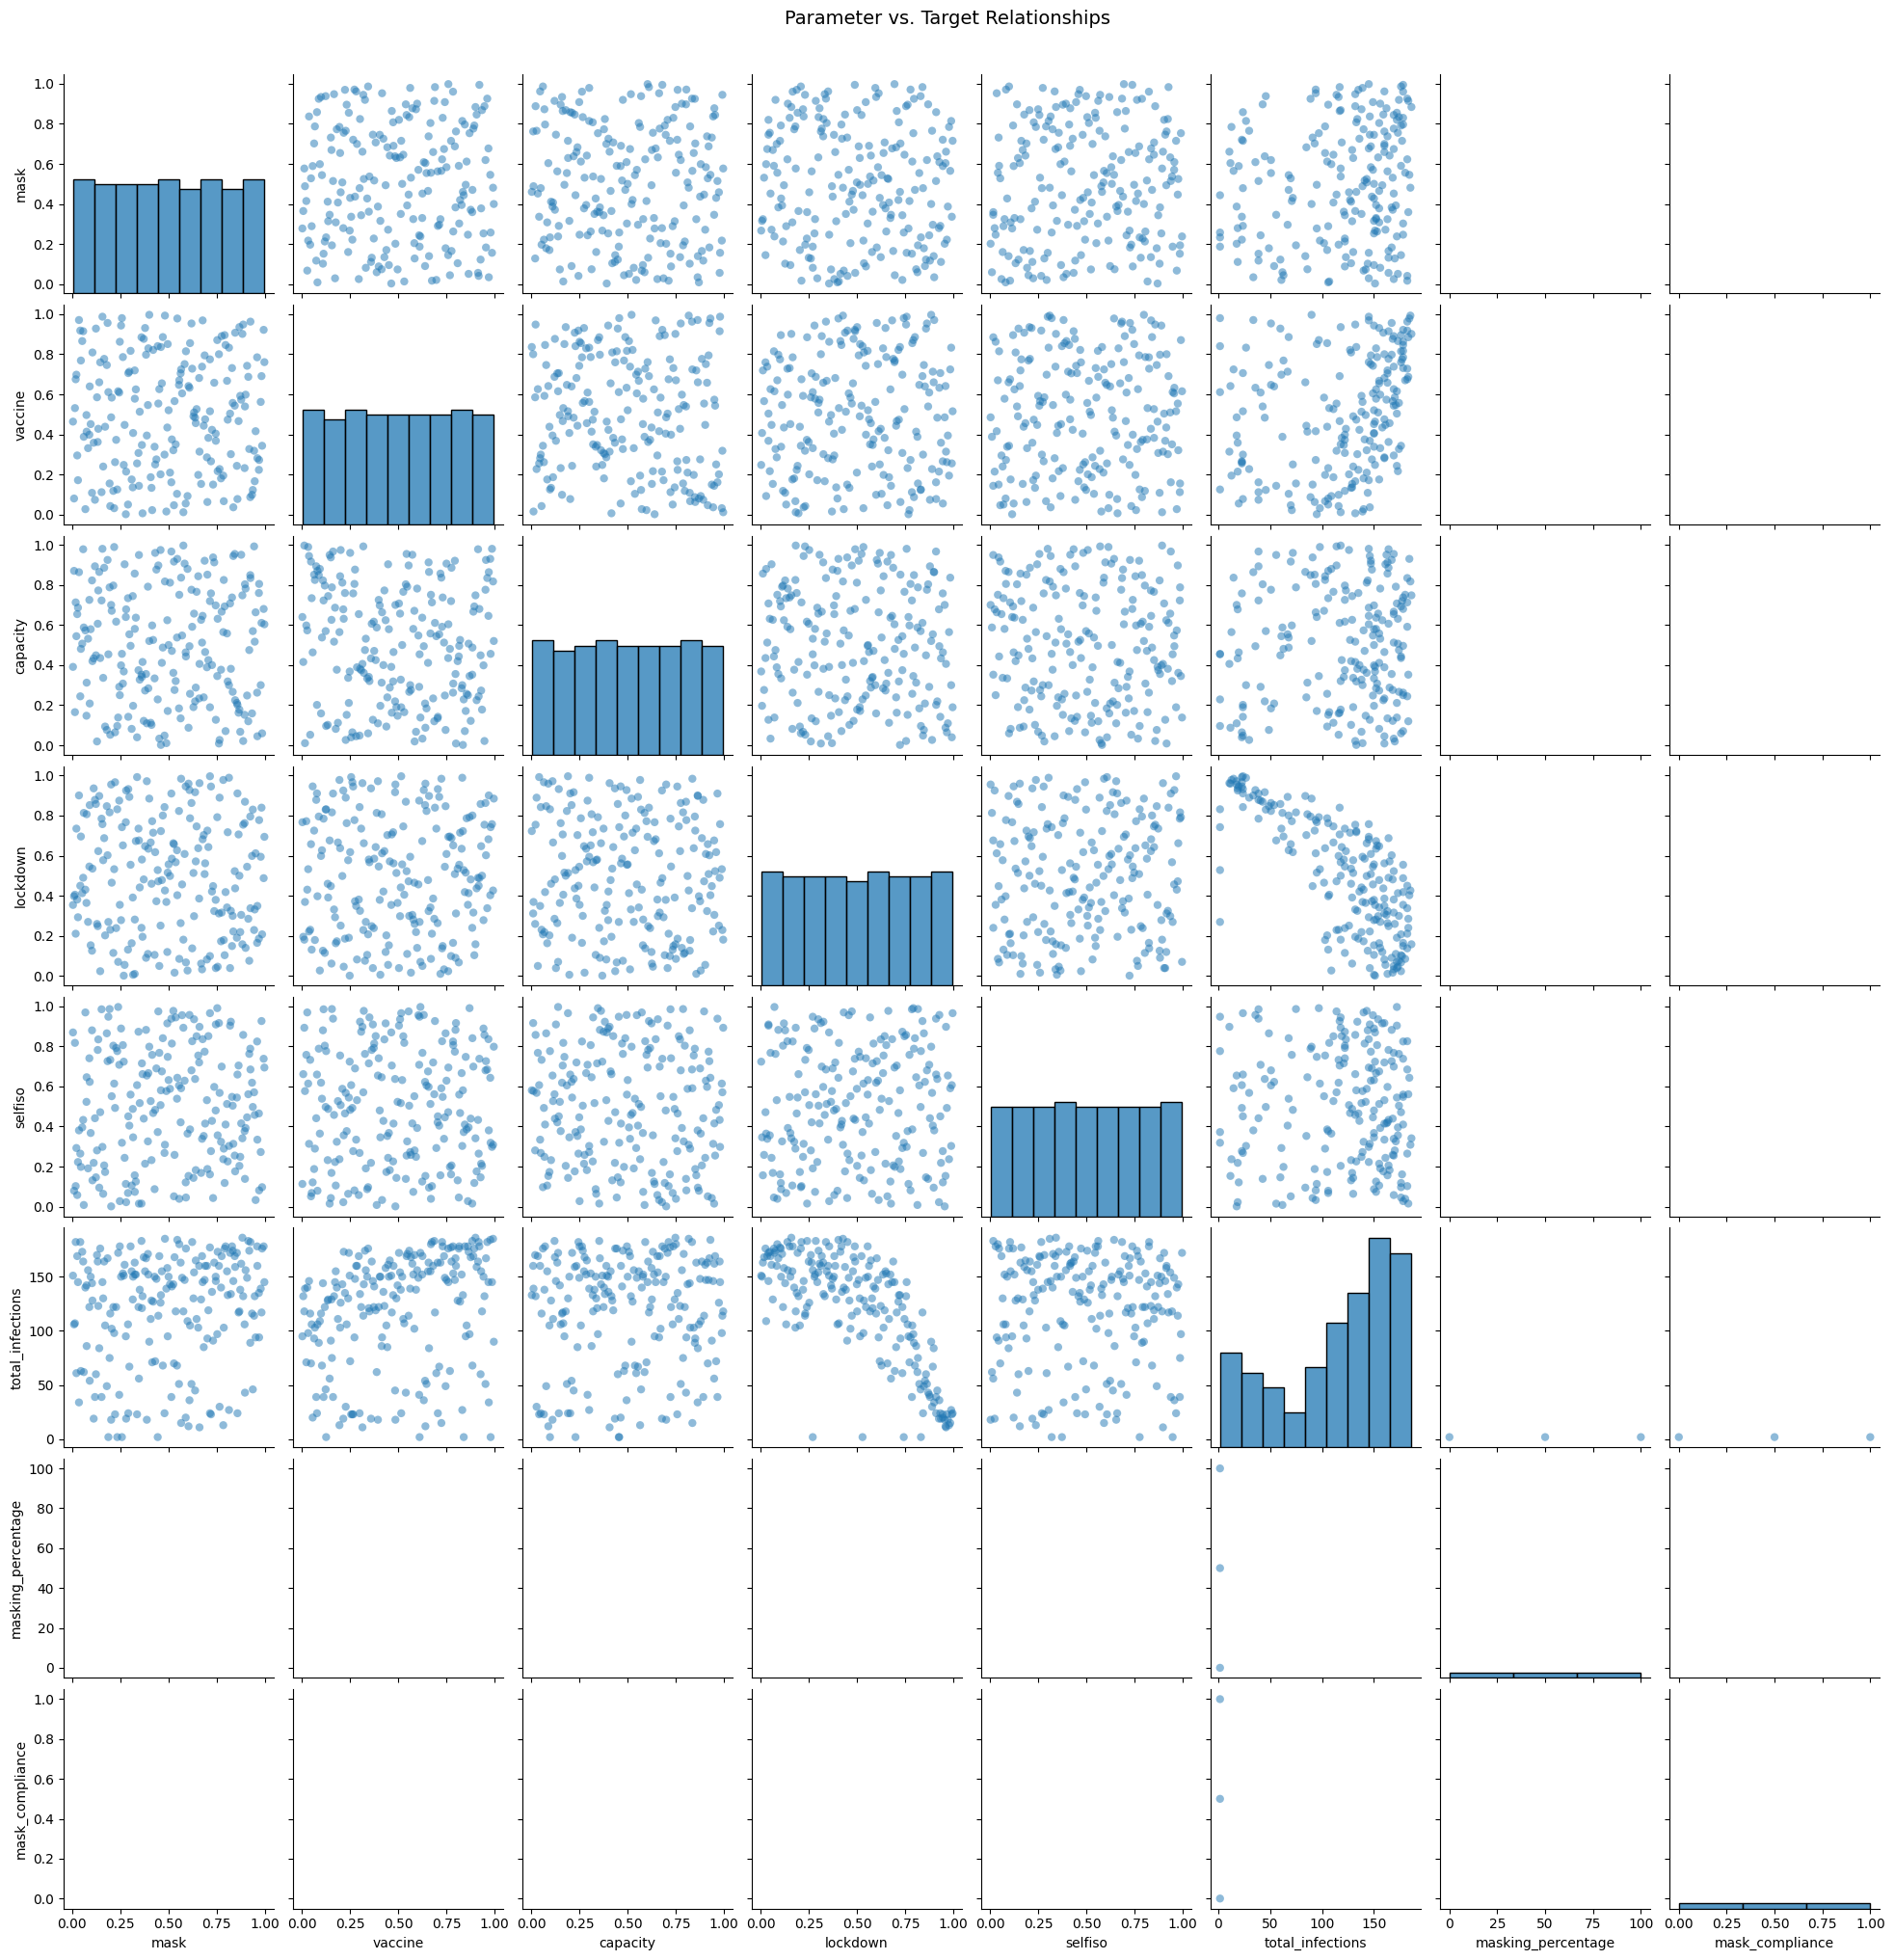

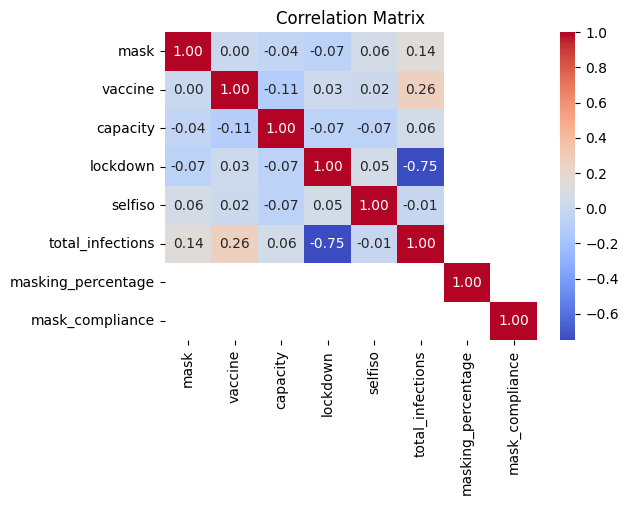

In [ ]:
sns.pairplot(
    df.reset_index().drop(columns='run_id'),
    diag_kind="hist",
    plot_kws={"alpha": 0.5, "edgecolor": "none"}
)
plt.suptitle("Parameter vs. Target Relationships", y=1.02, fontsize=14)
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
X = df.drop(columns='total_infections').copy()
y = df['total_infections'].copy()

X = X.apply(lambda col: col.fillna(col.median()) if col.isna().any() else col)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED
)
print(f"Train rows: {len(X_train)}, Test rows: {len(X_test)}")

Train rows: 164, Test rows: 42


In [ ]:
param_grid = {
    'n_estimators': [400, 800, 1200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.8, None]
}

rf_base = RandomForestRegressor(random_state=SEED, n_jobs=-1)
search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_grid,
    n_iter=25,
    scoring='neg_mean_absolute_error',
    cv=3,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("Best params ->", search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
🔎 Best params -> {'n_estimators': 1200, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}


In [ ]:
def report(model, X_, y_, tag):
    pred = model.predict(X_)
    print(f"{tag:5s} | MAE = {mean_absolute_error(y_, pred):,.0f}"
          f" | R² = {r2_score(y_, pred):.3f}")

report(best_rf, X_train, y_train, "Train")
report(best_rf, X_test,  y_test,  "Test")

Train | MAE = 10 | R² = 0.917
Test  | MAE = 19 | R² = 0.802


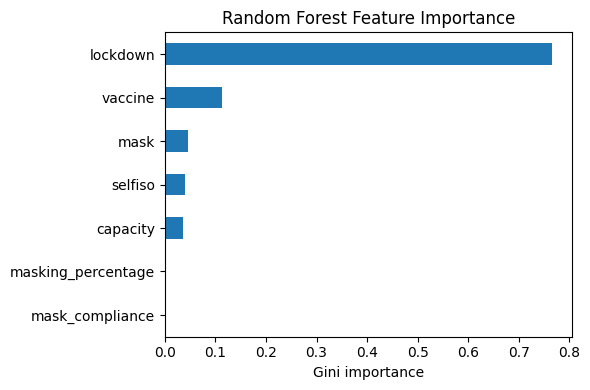

In [ ]:
fi = pd.Series(best_rf.feature_importances_, index=X.columns)
plt.figure(figsize=(6, 4))
fi.sort_values().plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.xlabel("Gini importance")
plt.tight_layout()
plt.show()

In [ ]:
def local_counterfactual(row, model, step=0.05):
    """
    Perturb each parameter by ±step (or flip 0/1 for binary),
    return list of dicts with absolute infection deltas.
    """
    base_pred = model.predict(row.values.reshape(1, -1))[0]
    impacts = []
    for col in row.index:
        orig = row[col]

        # Determine candidate new values
        if orig in (0, 1) and float(orig).is_integer():
            candidates = [1 - orig]  # flip 0→1 or 1→0
        else:
            candidates = [orig * (1 - step), orig * (1 + step)]

        for new_val in candidates:
            row_mod = row.copy()
            row_mod[col] = new_val
            new_pred = model.predict(row_mod.values.reshape(1, -1))[0]
            impacts.append({
                "run_id": row.name,
                "parameter": col,
                "orig_val": orig,
                "new_val": new_val,
                "pred_base": base_pred,
                "pred_new": new_pred,
                "abs_delta": abs(new_pred - base_pred)
            })
    return impacts

In [ ]:
from tqdm import tqdm

impact_rows = []
for rid, feat_row in tqdm(df.drop(columns='total_infections').iterrows(),
                          total=len(df), desc="Counterfactuals"):
    impact_rows.extend(local_counterfactual(feat_row, best_rf))

cf_df = pd.DataFrame(impact_rows)
print("cf_df shape:", cf_df.shape)
display(cf_df.head())

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted 

cf_df shape: (2881, 7)


,run_id,parameter,orig_val,new_val,pred_base,pred_new,abs_delta
0,run1,mask,0.60882,0.578379,30.436355,29.215262,1.221093
1,run1,mask,0.60882,0.639261,30.436355,30.584133,0.147778
2,run1,vaccine,0.63285,0.601208,30.436355,30.413369,0.022986
3,run1,vaccine,0.63285,0.664493,30.436355,31.586638,1.150283
4,run1,capacity,0.49454,0.469813,30.436355,30.309904,0.126451


In [ ]:
threshold = cf_df['abs_delta'].quantile(0.90)
hi_df = cf_df[cf_df['abs_delta'] >= threshold].sort_values(
    'abs_delta', ascending=False
)
print(f"High-impact threshold: |Δ| ≥ {threshold:,.0f}")
display(hi_df.head(20))

High-impact threshold: |Δ| ≥ 2


,run_id,parameter,orig_val,new_val,pred_base,pred_new,abs_delta
1574,run20,lockdown,0.50024,0.475228,46.644273,155.146703,108.502430
441,run127,lockdown,0.47844,0.502362,151.702486,45.883327,105.819159
2163,run58,lockdown,0.48174,0.505827,147.899000,72.491359,75.407642
1575,run20,lockdown,0.50024,0.525252,46.644273,108.867686,62.223413
871,run155,vaccine,0.61102,0.641571,104.512880,153.163351,48.650471
1602,run21,lockdown,0.51558,0.489801,97.774914,145.153098,47.378184
1182,run175,lockdown,0.84232,0.800204,34.140379,81.377195,47.236816
678,run142,lockdown,0.52825,0.501837,78.854610,34.001594,44.853016
2205,run60,lockdown,0.49012,0.514626,154.584744,116.370637,38.214106
2246,run63,lockdown,0.52291,0.496764,140.788903,105.858021,34.930882


/tmp/ipython-input-3375745264.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


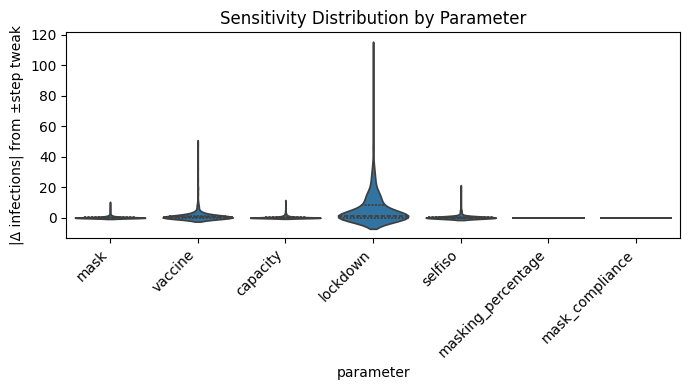

In [ ]:
plt.figure(figsize=(7, 4))
sns.violinplot(
    data=cf_df,
    x="parameter",
    y="abs_delta",
    inner="quartile",
    scale="width"
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("|Δ infections| from ±step tweak")
plt.title("Sensitivity Distribution by Parameter")
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(best_rf, 'rf_total_infections_model.joblib')
hi_df.to_csv('high_impact_counterfactuals.csv', index=False)
print("Model + flag list saved to working directory.")

✅ Model + flag list saved to working directory.
